In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [2]:
dir = Path('data/ECG_Image_data/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,data\ECG_Image_data\test\F\F0.png,F
1,data\ECG_Image_data\test\F\F104.png,F
2,data\ECG_Image_data\test\F\F113.png,F
3,data\ECG_Image_data\test\F\F115.png,F
4,data\ECG_Image_data\test\F\F118.png,F
...,...,...
24794,data\ECG_Image_data\test\V\V98.png,V
24795,data\ECG_Image_data\test\V\V981.png,V
24796,data\ECG_Image_data\test\V\V986.png,V
24797,data\ECG_Image_data\test\V\V987.png,V


In [3]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [4]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64

In [5]:
dataframe_test

,Filepath,Label
0,data\ECG_Image_data\test\M\M933.png,M
1,data\ECG_Image_data\test\F\F377.png,F
2,data\ECG_Image_data\test\Q\Q6746.png,Q
3,data\ECG_Image_data\test\Q\Q883.png,Q
4,data\ECG_Image_data\test\Q\Q6569.png,Q
...,...,...
955,data\ECG_Image_data\test\S\S1979.png,S
956,data\ECG_Image_data\test\N\N26059.png,N
957,data\ECG_Image_data\test\F\F418.png,F
958,data\ECG_Image_data\test\M\M971.png,M


In [6]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


In [7]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255
)

In [9]:
size=224
color_mode='rgb'
batch_size=32

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 960 validated image filenames belonging to 6 classes.


In [10]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

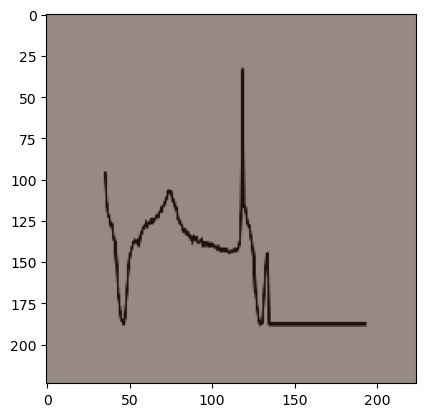

In [11]:
plt.imshow(test_images[0][0][3])

In [12]:
from keras.models import load_model
best_model=load_model('ECG_Model1.h5')
results = best_model.evaluate(test_images, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))

     Test Loss: 0.2150
 Test Accuracy: 92.5000%
Test Precision: 92.5810%
   Test Recall: 92.2917%
      Test AUC: 0.9935


In [13]:
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 24s 787ms/step


array([[5.0358109e-09, 9.8558432e-01, 7.1727308e-28, 1.5688406e-18,
        1.4415623e-02, 7.5304087e-08],
       [8.8594067e-01, 1.3894689e-05, 9.3833419e-10, 1.4198205e-04,
        5.9382068e-03, 1.0796528e-01],
       [9.3017751e-04, 1.2501819e-08, 1.3887283e-03, 9.8632127e-01,
        5.1681724e-07, 1.1359311e-02],
       ...,
       [8.7409532e-01, 7.8328467e-06, 8.1841103e-09, 5.1352096e-04,
        3.0313691e-03, 1.2235203e-01],
       [8.3728702e-10, 9.8730576e-01, 4.3578923e-30, 7.5395742e-20,
        1.2694158e-02, 2.8482557e-08],
       [3.7714931e-06, 2.6268978e-11, 9.2687285e-01, 7.3103100e-02,
        1.3240813e-10, 2.0322419e-05]], dtype=float32)

In [15]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 3, 3, 3, 1, 5, 1, 2, 2, 5, 3, 1, 2, 4, 4, 2, 4, 5, 2, 1, 3,
       4, 2, 4, 4, 4, 3, 2, 5, 3, 1, 2, 3, 2, 3, 4, 5, 4, 5, 0, 5, 4, 3,
       1, 4, 1, 4, 1, 0, 2, 2, 0, 3, 3, 0, 5, 0, 4, 0, 3, 5, 2, 5, 3, 0,
       5, 3, 1, 5, 1, 5, 5, 0, 5, 3, 0, 2, 0, 2, 0, 0, 4, 3, 2, 5, 2, 4,
       5, 5, 4, 5, 0, 1, 4, 2, 4, 1, 4, 2, 5, 2, 4, 5, 4, 4, 1, 0, 1, 4,
       3, 4, 4, 5, 2, 2, 2, 3, 3, 3, 0, 2, 4, 0, 1, 3, 4, 4, 4, 5, 4, 5,
       2, 4, 2, 0, 3, 3, 2, 0, 4, 2, 1, 3, 0, 0, 4, 3, 2, 1, 5, 3, 4, 4,
       1, 2, 4, 3, 0, 3, 3, 5, 5, 3, 1, 1, 4, 0, 3, 0, 5, 4, 1, 1, 0, 5,
       2, 5, 0, 2, 5, 0, 4, 3, 4, 4, 4, 1, 4, 2, 1, 4, 3, 4, 4, 4, 0, 0,
       5, 1, 5, 0, 5, 0, 1, 2, 0, 2, 4, 0, 0, 3, 0, 4, 2, 4, 1, 0, 5, 0,
       0, 0, 3, 2, 4, 2, 0, 5, 2, 4, 1, 2, 4, 0, 5, 2, 5, 0, 4, 4, 3, 2,
       4, 4, 0, 5, 0, 3, 2, 3, 2, 4, 2, 3, 4, 4, 3, 3, 0, 5, 4, 0, 2, 1,
       5, 1, 3, 2, 5, 5, 1, 0, 3, 5, 0, 2, 0, 1, 4, 5, 4, 4, 0, 0, 2, 3,
       3, 2, 0, 5, 4, 3, 1, 2, 1, 0, 1, 0, 5, 2, 3,

In [16]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)

report = classification_report(test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)

[[149   0   0   0   0  11]
 [  0 120   0   0  40   0]
 [  0   0 158   2   0   0]
 [  0   0   1 159   0   0]
 [  0   2   0   0 158   0]
 [ 16   0   0   0   0 144]]
              precision    recall  f1-score   support

           F     0.9030    0.9313    0.9169       160
           M     0.9836    0.7500    0.8511       160
           N     0.9937    0.9875    0.9906       160
           Q     0.9876    0.9938    0.9907       160
           S     0.7980    0.9875    0.8827       160
           V     0.9290    0.9000    0.9143       160

    accuracy                         0.9250       960
   macro avg     0.9325    0.9250    0.9244       960
weighted avg     0.9325    0.9250    0.9244       960



Confusion matrix, without normalization


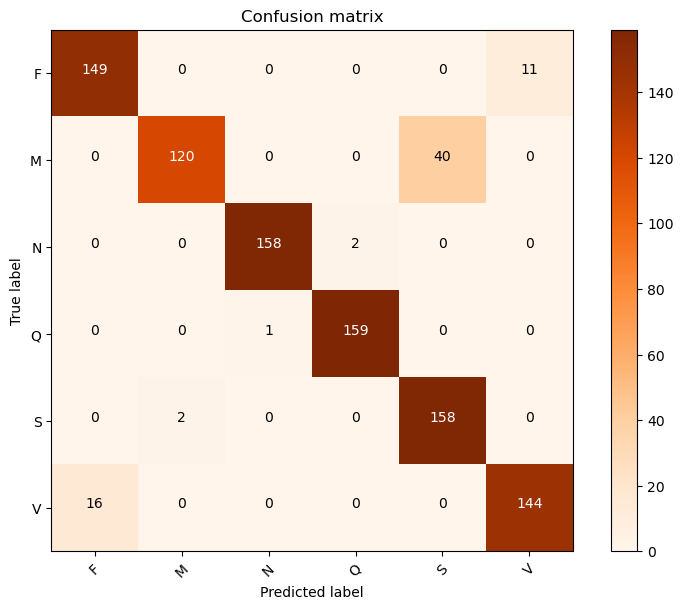

In [17]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '20'
    
    
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')


Normalized confusion matrix


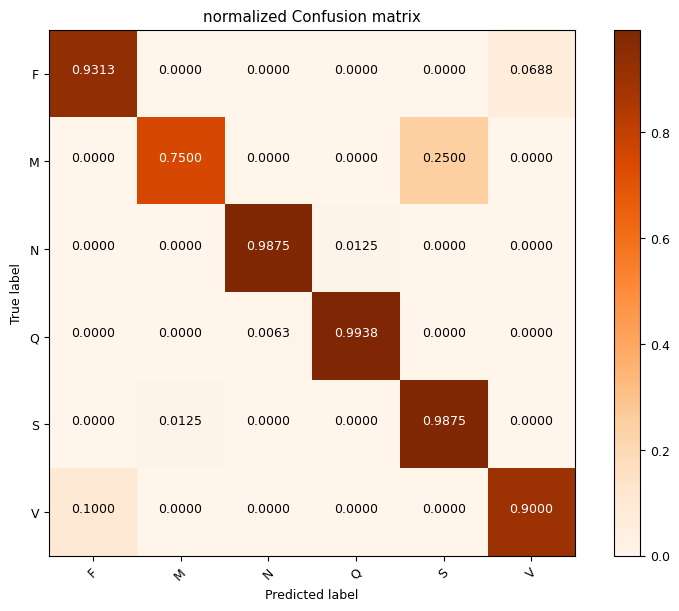

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '7'
    
    
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')
